In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Constants
dataset_dir = 'Indian-Traffic Sign-Dataset'
image_dir = os.path.join(dataset_dir, 'Images')
csv_file = os.path.join(dataset_dir, 'traffic_sign.csv')
image_size = (32, 32)  # Target image size for resizing
num_classes = 58  # Number of traffic sign classes


In [3]:
# Load CSV file
df = pd.read_csv(csv_file)

In [4]:
# Map ClassId to Class Name
class_map = {row['ClassId']: row['Name'] for index, row in df.iterrows()}

In [5]:
 # Initialize lists to store images and labels
images = []
labels = []

In [6]:
# Load images and labels
for class_id_folder in os.listdir(image_dir):
    class_id = int(class_id_folder)
    class_name = class_map[class_id]

    for image_file in os.listdir(os.path.join(image_dir, class_id_folder)):
        image_path = os.path.join(image_dir, class_id_folder, image_file)
        image = Image.open(image_path).convert('RGB')
        image = image.resize(image_size)  # Resize image to target size
        images.append(np.array(image))
        labels.append(class_id)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)


In [7]:
# Normalize pixel values to range 0-1
images = images.astype('float32') / 255.0

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 58)                  │           7,482 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,394 (649.98 KB)

 Trainable params: 166,394 (649.98 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
batch_size = 32
epochs = 20

datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=False,
                             vertical_flip=False,
                             fill_mode='nearest')

# Fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(X_train) / batch_size),  # Convert float to int
                    epochs=epochs,
                    validation_data=(X_val, y_val))

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print(f'Validation accuracy: {val_acc:.4f}')
print(f'Validation loss: {val_loss:.4f}')

Epoch 1/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.1049 - loss: 3.6896 - val_accuracy: 0.4365 - val_loss: 1.9309
Epoch 2/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2188 - loss: 2.8442 - val_accuracy: 0.4311 - val_loss: 1.9389
Epoch 3/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.3896 - loss: 2.1451 - val_accuracy: 0.6780 - val_loss: 1.1146
Epoch 4/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5938 - loss: 1.3100 - val_accuracy: 0.6780 - val_loss: 1.1071
Epoch 5/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5560 - loss: 1.4574 - val_accuracy: 0.7564 - val_loss: 0.7735
Epoch 6/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6250 - loss: 1.8130 - val_accuracy: 0.7589 - val_loss: 0.7726
Epoch 7/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.6233 - loss: 1.1673 - val_accuracy: 0.7968 - val_loss: 0.6593
Epoch 8/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7812 - loss: 0.7900 - val_accu

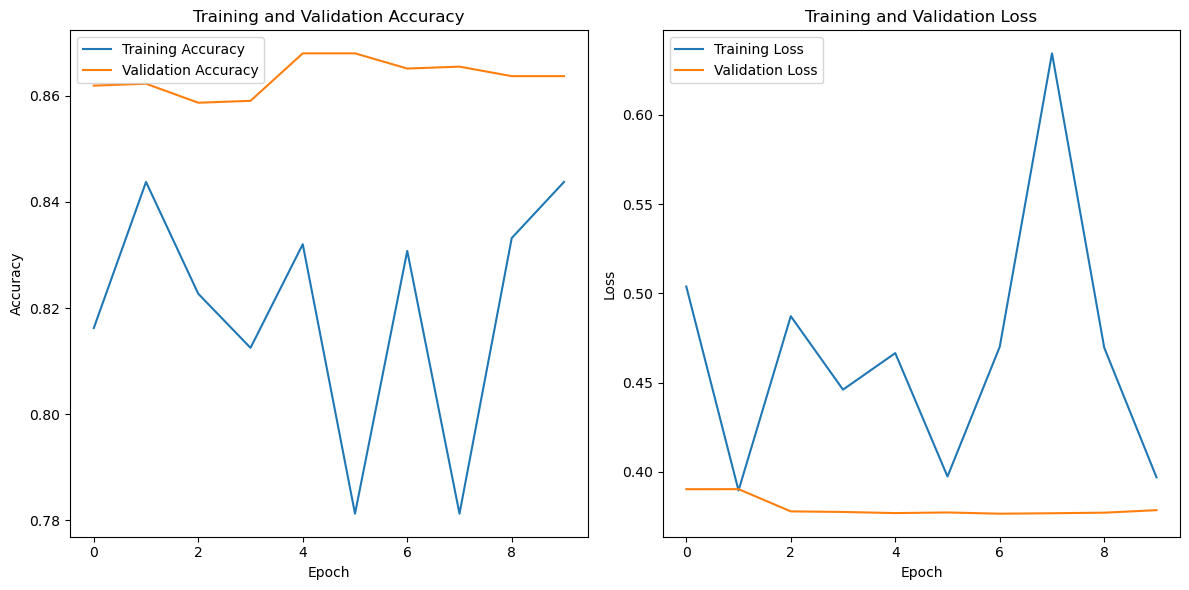

In [14]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
new_optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate
model.compile(optimizer=new_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(X_train) / batch_size),
                    epochs=10,  # Train for additional epochs
                    validation_data=(X_val, y_val))

# Evaluate updated model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print(f'Updated Validation accuracy: {val_acc:.4f}')
print(f'Updated Validation loss: {val_loss:.4f}')

Epoch 1/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8304 - loss: 0.4556 - val_accuracy: 0.8630 - val_loss: 0.3699
Epoch 2/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.2986 - val_accuracy: 0.8637 - val_loss: 0.3706
Epoch 3/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.8402 - loss: 0.4302 - val_accuracy: 0.8619 - val_loss: 0.3865
Epoch 4/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7812 - loss: 0.2954 - val_accuracy: 0.8619 - val_loss: 0.3874
Epoch 5/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8297 - loss: 0.4544 - val_accuracy: 0.8626 - val_loss: 0.3717
Epoch 6/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.6142 - val_accuracy: 0.8637 - val_loss: 0.3717
Epoch 7/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.8375 - loss: 0.4429 - val_accuracy: 0.8615 - val_loss: 0.3634
Epoch 8/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.4385 - val_accu

In [16]:
# Save the updated model
model.save('traffic_sign_recognition_model_updated.h5')
print('Updated Model saved successfully.')

Updated Model saved successfully.
